In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
import timm

In [2]:
# Função para carregar os nomes dos arquivos de uma pasta
def load_nii_files_from_directory(directory):
    nii_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.nii.gz'):
                file_path = os.path.join(root, file)
                nii_files.append(file_path)
    return nii_files

# Função para carregar e pré-processar os dados dos arquivos .nii
def load_and_preprocess_nii_files(nii_files):
    data = []
    labels = []
    filenames = []

    for file_path in nii_files:
        file_name = os.path.basename(file_path)
        
        nii_file = nib.load(file_path)
        nii_data = nii_file.get_fdata()
        
        nii_data = (nii_data - np.min(nii_data)) / (np.max(nii_data) - np.min(nii_data))
        
        if file_name.startswith('BraTS'):
            label = 0 
        else:
            label = 1  
        
        data.append(nii_data)
        labels.append(label)
        filenames.append(file_name)
    
    return np.array(data), np.array(labels), filenames


In [3]:
data_dir_real = 'original_data/real'
data_dir_fake = 'original_data/fake'

# Carregar arquivos .nii de cada pasta
real_nii_files = load_nii_files_from_directory(data_dir_real)
fake_nii_files = load_nii_files_from_directory(data_dir_fake)

# Carregar e pré-processar dados dos arquivos .nii
real_data, real_labels, real_filenames = load_and_preprocess_nii_files(real_nii_files)
fake_data, fake_labels, fake_filenames = load_and_preprocess_nii_files(fake_nii_files)

# Concatenar dados e labels
data = np.concatenate((real_data, fake_data), axis=0)
labels = np.concatenate((real_labels, fake_labels), axis=0)

# Concatenar nomes dos arquivos
filenames = np.concatenate((real_filenames, fake_filenames), axis=0)

# Processamento dos Dados

In [4]:
# Selecionar apenas o slice central de cada volume de imagem
data_central_slices = data[:, :, :, data.shape[-1] // 2]

# Redimensionar cada arquivo para o formato 224x224
resized_data = [cv2.resize(slice, (224, 224)) for slice in data_central_slices]
resized_data = np.array(resized_data)

# Expandir dimensão para canais de cores
input_data = np.expand_dims(resized_data, axis=1)
input_data = np.repeat(input_data, repeats=3, axis=1)

# Definir os datasets de treino e teste

In [5]:
test_size = 0.3
train_inputs, test_inputs, train_labels, test_labels, train_filenames, test_filenames = train_test_split(
    input_data, labels, filenames, test_size=test_size, stratify=labels, random_state=42)

In [6]:
LEARNING_RATE = 1e-4
batch_size = 32
EPOCHS = 200

In [7]:
# Set random seeds for reproducibility
import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [8]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)

In [9]:
# Congelar camadas pré-treinadas
for param in model.parameters():
    param.requires_grad = False

# Modificar a camada de classificação
model.head = nn.Linear(model.head.in_features, 1)
model.head = model.head.float()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [10]:
loss_function = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

class CustomDataset(Dataset):
    def __init__(self, inputs, labels, filenames, transform=None):
        self.inputs = inputs
        self.labels = labels
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input = self.inputs[idx]
        label = self.labels[idx]
        filename = self.filenames[idx]

        if self.transform:
            input_data = self.transform(input)

        return input, label, filename

transform = ToTensor()

train_dataset = CustomDataset(train_inputs, train_labels, train_filenames, transform=transform)
test_dataset = CustomDataset(test_inputs, test_labels, test_filenames, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## CheckPoints

In [11]:
# Função para salvar um checkpoint do modelo
def save_checkpoint(model, optimizer, epoch, val_loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint salvo em {filename}")

# Função para carregar um checkpoint do modelo
def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
    print(f"Checkpoint carregado de {filename}")
    return epoch, val_loss

# Treinar o modelo no conjunto de dados de treino

In [12]:
def train_model(model, optimizer, train_loader, test_loader, loss_function, EPOCHS, device):
    
    train_losses = []
    val_losses = []

    # Verifica se há um checkpoint existente para carregar
    #checkpoint_path = 'checkpoint/my_checkpoint_epoch_10.pth'
    #start_epoch = 0
    #if os.path.exists(checkpoint_path):
    #    start_epoch, val_loss = load_checkpoint(model, optimizer, checkpoint_path)
    #    print(f"Retomando treinamento a partir da época {start_epoch} com validação loss {val_loss:.4f}")
        
        
    for epoch in range(EPOCHS):
        model.train()
        running_train_loss = 0.0
        
        # Treino
        for inputs, labels, _ in train_loader:
            inputs = inputs.to(device).float()
            labels = labels.unsqueeze(1).float().to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validação
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels, _ in test_loader:
                inputs = inputs.to(device).float()
                labels = labels.unsqueeze(1).float().to(device)
                
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
            
        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")

        # Salvar checkpoint em intervalos ou na última época
        if (epoch + 1) % 10 == 0 or (epoch + 1) == EPOCHS:
            filename = f'checkpoint/my_checkpoint_epoch_{epoch + 1}.pth'
            save_checkpoint(model, optimizer, epoch + 1, epoch_val_loss, filename)
    
    return train_losses, val_losses

In [13]:
train_losses, val_losses = train_model(model, optimizer, train_loader, test_loader, loss_function, EPOCHS, device)

Epoch 1/200: Train Loss = 0.6832, Val Loss = 0.6307
Epoch 2/200: Train Loss = 0.6586, Val Loss = 0.6092
Epoch 3/200: Train Loss = 0.6368, Val Loss = 0.5908
Epoch 4/200: Train Loss = 0.6203, Val Loss = 0.5734
Epoch 5/200: Train Loss = 0.6058, Val Loss = 0.5589
Epoch 6/200: Train Loss = 0.5937, Val Loss = 0.5469
Epoch 7/200: Train Loss = 0.5825, Val Loss = 0.5363
Epoch 8/200: Train Loss = 0.5708, Val Loss = 0.5271
Epoch 9/200: Train Loss = 0.5610, Val Loss = 0.5186
Epoch 10/200: Train Loss = 0.5514, Val Loss = 0.5099
Checkpoint salvo em checkpoint/my_checkpoint_epoch_10.pth
Epoch 11/200: Train Loss = 0.5419, Val Loss = 0.5013
Epoch 12/200: Train Loss = 0.5329, Val Loss = 0.4929
Epoch 13/200: Train Loss = 0.5237, Val Loss = 0.4852
Epoch 14/200: Train Loss = 0.5151, Val Loss = 0.4775
Epoch 15/200: Train Loss = 0.5061, Val Loss = 0.4702
Epoch 16/200: Train Loss = 0.4982, Val Loss = 0.4632
Epoch 17/200: Train Loss = 0.4901, Val Loss = 0.4564
Epoch 18/200: Train Loss = 0.4827, Val Loss = 0.45

## Plot Learning Curve

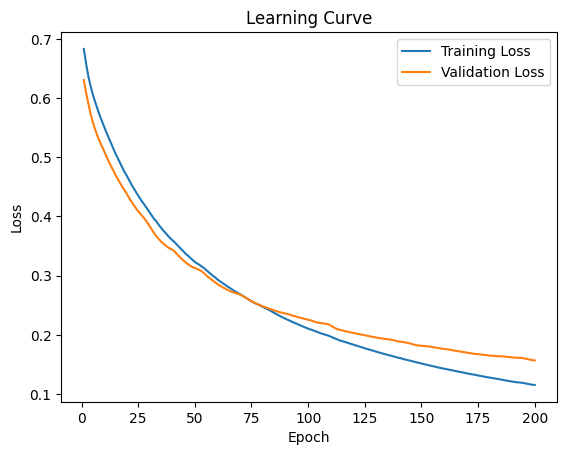

In [14]:
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Avaliar o Modelo

In [15]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_results = []
    
    for inputs, labels, filenames in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.unsqueeze(1).float().to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            # Calcular probabilidades usando sigmoide
            probs = torch.sigmoid(outputs).cpu().numpy()
            
            # Converter probs para tensor PyTorch antes de aplicar torch.round
            probs_tensor = torch.from_numpy(probs)
            rounded_predictions = torch.round(probs_tensor)
            
            # Converter previsões arredondadas e true labels para numpy arrays
            predictions = rounded_predictions.cpu().numpy()
            true_labels = labels.cpu().numpy()
            
            # Coletar resultados do teste
            for pred, prob, true_label, filename in zip(predictions, probs, true_labels, filenames):
                test_results.append({
                    'filename': filename,
                    'true_label': true_label,
                    'prediction': pred,
                    'probability': prob
                })

    return test_results


In [16]:
# Após avaliar o modelo
test_results = evaluate_model(model, test_loader, device)

# Separar true labels e predictions dos resultados de teste
true_labels = [result['true_label'] for result in test_results]
predictions = [result['prediction'] for result in test_results]


In [17]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f"Accuracy:{accuracy * 100:.4f}%")
print(f"Precision:{precision * 100:.4f}%")
print(f"Recall:{recall * 100:.4f}%")
print(f"Pontuação F1:{f1 * 100:.4f}%")

Accuracy:96.6667%
Precision:93.7500%
Recall:100.0000%
Pontuação F1:96.7742%


## Scans

#### scans sinteticos classificados como reais:

In [18]:
max_prob = -1
max_prob_scan = None
matches = []

for result in test_results:
    if result['true_label'][0] == 1 and result['prediction'][0] == 0:
        matches.append(result)
        prob = result['probability'][0]
        
        if prob > max_prob:
            max_prob = prob
            max_prob_scan = result

if matches:
    print("Exames com true_label=1 e prediction=0:")
    for match in matches:
        print(f"Arquivo: {match['filename']}")
        print(f"True label: {match['true_label'][0]:.2f}")
        print(f"Prediction: {match['prediction'][0]:.2f}")
        print(f"Probabilidade: {match['probability'][0]:.4f}\n")
else:
    print("Nenhum exame correspondente encontrado.")


Nenhum exame correspondente encontrado.


### scans sinteticos classificados como sinteticos

In [19]:
max_prob = -1
max_prob_scan = None

matches = []

for result in test_results:
    if result['true_label'][0] == 1 and result['prediction'][0] == 1:
        matches.append(result)
        prob = result['probability'][0]
        if prob > max_prob:
            max_prob = prob
            max_prob_scan = result

if matches:
    print("Exames com true_label=1 e prediction=1:")
    for match in matches:
        print(f"Arquivo: {match['filename']}")
        print(f"True label: {match['true_label'][0]:.2f}")
        print(f"Prediction: {match['prediction'][0]:.2f}")
        print(f"Probabilidade: {match['probability'][0]:.4f}\n")
else:
    print("Nenhum exame correspondente encontrado.")

if max_prob_scan:
    print("MRI com true_label=1 e prediction=1 com maior probabilidade:")
    print(f"Arquivo: {max_prob_scan['filename']}")
    print(f"True label: {max_prob_scan['true_label'][0]:.2f}")
    print(f"Prediction: {max_prob_scan['prediction'][0]:.2f}")
    print(f"Probabilidade: {max_prob_scan['probability'][0]:.4f}")
else:
    print("Nenhum exame correspondente encontrado com probabilidade máxima.")


Exames com true_label=1 e prediction=1:
Arquivo: synt_BraTS-GLI-00016-001_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.9177

Arquivo: synt_BraTS-GLI-00008-001_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.9163

Arquivo: synt_BraTS-GLI-00024-001_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.5929

Arquivo: synt_BraTS-GLI-00043-000_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.9530

Arquivo: synt_BraTS-GLI-00028-000_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.9541

Arquivo: synt_BraTS-GLI-00011-000_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.8714

Arquivo: synt_BraTS-GLI-00033-000_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.6958

Arquivo: synt_BraTS-GLI-00019-000_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.5227

Arquivo: synt_BraTS-GLI-00059-001_0000.nii.gz
True label: 1.00
Prediction: 1.00
Probabilidade: 0.9445

Arquivo: synt_BraTS-GLI-00032-001

### scans reais classificados como reais

In [20]:
max_prob = -1
max_prob_scan = None

matches = []
for result in test_results:
    if result['true_label'][0] == 0 and result['prediction'][0] == 0:
        matches.append(result)
        prob = result['probability'][0]
        if prob > max_prob:
            max_prob = prob
            max_prob_scan = result

if matches:
    print("Exames com true_label=0 e prediction=0:")
    for match in matches:
        print(f"Arquivo: {match['filename']}")
        print(f"True label: {match['true_label'][0]}")
        print(f"Prediction: {match['prediction'][0]}")
        print(f"Probabilidade: {match['probability'][0]:.4f}\n")
else:
    print("Nenhum exame correspondente encontrado.")

if max_prob_scan:
    print("MRI com true_label=0 e prediction=0 com maior probabilidade:")
    print(f"Arquivo: {max_prob_scan['filename']}")
    print(f"True label: {max_prob_scan['true_label'][0]:.2f}")
    print(f"Prediction: {max_prob_scan['prediction'][0]:.2f}")
    print(f"Probabilidade: {max_prob_scan['probability'][0]:.4f}")
else:
    print("Nenhum exame correspondente encontrado com probabilidade máxima.")

Exames com true_label=0 e prediction=0:
Arquivo: BraTS-GLI-00020-000_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.0679

Arquivo: BraTS-GLI-00031-001_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.2113

Arquivo: BraTS-GLI-00008-001_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.0915

Arquivo: BraTS-GLI-00002-000_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.2157

Arquivo: BraTS-GLI-00024-000_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.0243

Arquivo: BraTS-GLI-00051-000_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.0724

Arquivo: BraTS-GLI-00054-000_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.1433

Arquivo: BraTS-GLI-00021-000_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.2000

Arquivo: BraTS-GLI-00048-000_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.0938

Arquivo: BraTS-GLI-00005-000_0000.nii.gz
True label: 0.0
Prediction: 0.0
Probabilidade: 0.0209



### scans reais classificados como sinteticos

In [21]:
max_prob = -1
max_prob_scan = None

matches = []
for result in test_results:
    if result['true_label'][0] == 0 and result['prediction'][0] == 1:
        matches.append(result)
        prob = result['probability'][0]
        if prob > max_prob:
            max_prob = prob
            max_prob_scan = result

if matches:
    print("Exames com true_label=0 e prediction=1:")
    for match in matches:
        print(f"Arquivo: {match['filename']}")
        print(f"True label: {match['true_label'][0]}")
        print(f"Prediction: {match['prediction'][0]}")
        print(f"Probabilidade: {match['probability'][0]:.4f}\n")
else:
    print("Nenhum exame correspondente encontrado.")

if max_prob_scan:
    print("MRI com true_label=0 e prediction=1 com maior probabilidade:")
    print(f"Arquivo: {max_prob_scan['filename']}")
    print(f"True label: {max_prob_scan['true_label'][0]}")
    print(f"Prediction: {max_prob_scan['prediction'][0]}")
    print(f"Probabilidade: {max_prob_scan['probability'][0]:.4f}")
else:
    print("Nenhum exame correspondente encontrado com probabilidade máxima.")

Exames com true_label=0 e prediction=1:
Arquivo: BraTS-GLI-00056-001_0000.nii.gz
True label: 0.0
Prediction: 1.0
Probabilidade: 0.6467

MRI com true_label=0 e prediction=1 com maior probabilidade:
Arquivo: BraTS-GLI-00056-001_0000.nii.gz
True label: 0.0
Prediction: 1.0
Probabilidade: 0.6467
